<a href="https://colab.research.google.com/github/kraftpunk97/FashionMNIST-with-keras/blob/master/Fashion_MNIST_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST classification using Keras

<p>This notebook is a result of my experimentation with keras, which is something I've been wanting to try for a long time. I don't really like TensorFlow because I feel its way of doing things is way too convoluted. [keras](https://keras.io) is an API that sits on top of TensorFlow and uses a relatively easy-to-understand syntax, so that we don't have to deal with the guts of TensorFlow; keras takes care of it for us.</p><br>

<p>In this notebook, we will be tackling the Fashion MNIST dataset. We will be training three increasingly complex CNNs and then we populate our dataset using data augmentation techniques and further train the three models on the augmented dataset.</p><br>

We start off by importing our requirerd libraries. They are `tensorflow.keras` for the nerual network, `numpy` for linear algebra and `matplotlib.pyplot` for drawing pretty pictures...

In [0]:
import tensorflow as tf
from tensorflow import keras


import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.14.0


We download our dataset which can be done easily, thanks to `keras`. We further proceed to divide this dataset into training data and testing data.

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Each unique label value refers to a particular type of clothing item. We assign each type to that value...

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

num_classes = len(class_names)

Further dividing the original training data into actual training data (80%) and  cross validation data (20%)...

In [0]:
def gen_train_validation(train_images, train_labels, size=0.8):
  train_idx = np.random.choice(len(train_images), np.int(np.floor(size*len(train_images))), replace=False)
  cv_idx = [i for i in range(len(train_images)) if i not in train_idx]
  train_images_, train_labels_ = train_images[train_idx], train_labels[train_idx]
  cv_images, cv_labels = train_images[cv_idx], train_labels[cv_idx]
  return train_images_, train_labels_, cv_images, cv_labels


train_images, train_labels, cv_images, cv_labels = gen_train_validation(train_images, train_labels)

print("Shape of training images : {}".format(train_images.shape))
print("Shape of Cross Validation images : {}".format(cv_images.shape))
print("Shape of testing images : {}".format(test_images.shape))

Shape of training images : (48000, 28, 28)
Shape of Cross Validation images : (12000, 28, 28)
Shape of testing images : (10000, 28, 28)


In [0]:
_, image_rows, image_cols = train_images.shape
input_shape = (image_rows, image_cols, 1)

print(input_shape)

(28, 28, 1)


Visualising a sample image...

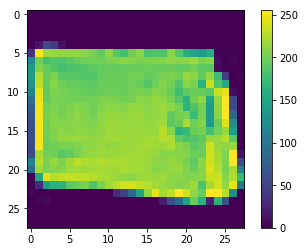

Bag


In [0]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()
print(class_names[train_labels[0]])

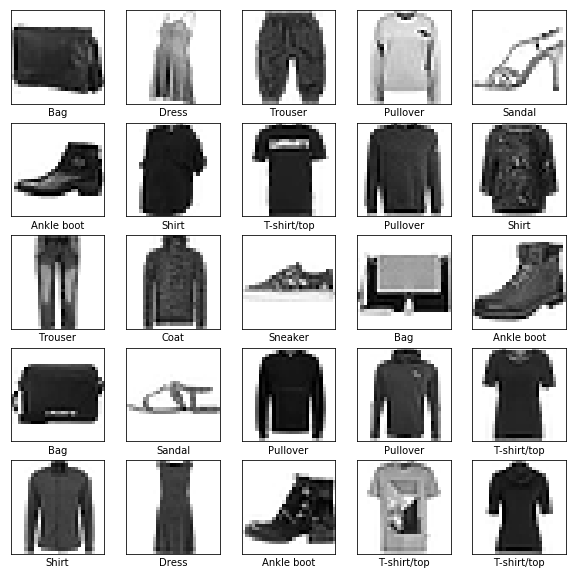

In [0]:
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i]])
plt.show()

Preprocessing the images by appending an extra dimension to the images, because that is something that keras requires us to do...

In [0]:
def preprocess(images):
  return images.reshape((len(images), image_rows, image_cols, 1))

train_images = preprocess(train_images)
cv_images = preprocess(cv_images)
test_images = preprocess(test_images)

print("Shape of training images : {}".format(train_images.shape))
print("Shape of Cross Validation images : {}".format(cv_images.shape))
print("Shape of testing images : {}".format(test_images.shape))

Shape of training images : (48000, 28, 28, 1)
Shape of Cross Validation images : (12000, 28, 28, 1)
Shape of testing images : (10000, 28, 28, 1)


Scaling the values of the individual pixels from 0->255 to 0->1 for reduced computational complexity..

In [0]:
train_images = train_images.astype('float32') / 255
cv_images = cv_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

## Utilites

In this section, we define a few utilites that will help us better understand our model and the results of the training process.

In [0]:
# Prints the summary of the neural network and its constituent layers...
def print_summary(section):
  print("\n\n\n{} summary--".format(section.name))
  section.summary()

# Plots the results of training process. We plot two graphs in which we compare
# the training and CV loss and training and CV accuracy
def plot_progress(history_cnn):
  acc = history_cnn.history['acc']
  val_acc = history_cnn.history['val_acc']
  loss = history_cnn.history['loss']
  val_loss = history_cnn.history['val_loss']
  
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, "r", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.legend()
  plt.figure()
  
  plt.plot(epochs, loss, "r", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.legend()
  plt.show()

  
# This helper function will help us see the variation in a metric across various
# models...
def plot_metric_across_models(histories, metric, colors):
  metric_collection = [history.history[metric] for history in histories]
  
  epochs = range(len(metric_collection[0]))
  
  for history, metric_arr, color in zip(histories, metric_collection, colors):
    plt.plot(epochs, metric_arr, color, label=history.model.name)
  
  plt.xlabel("#epochs")
  plt.ylabel(metric)
  plt.legend()
  plt.show()

## Hyperparameters

We use this opportunity to define our hyperparameters. Each model will be trained for 100 epochs and in batches of 256.

In [0]:
epochs = 20
batch_size = 256

## 1-Conv CNN (`model_cnn1`)

We describe a model that contains only one Convolution layer. We will use the ReLU activation function and use Maxpooling to summarise the patches of the feature maps and to downsample the features. We use the DropOut method to regularize our model. Following is a brief summary of the model...

(`conv_layer11`)\[ Conv ---> MaxPool ----> DropOut] ----><br>
Unroll ----><br>
(`dense_layer11`)\[ Dense -----> Dense ]

In [0]:
conv_layer11 = keras.Sequential([
    # Convolutional layers
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2)
], name="conv_layer11")


dense_layer11 = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(num_classes, activation=tf.nn.softmax)
], name="dense_layer11")

model_cnn1 = keras.Sequential([
    # Convolutional layers
    conv_layer11,
    # Unrolling...
    keras.layers.Flatten(),
    
    # Feeding the unrolled vector to the FC layers...
    dense_layer11
], name="model_cnn1")

print_summary(conv_layer11)
print_summary(dense_layer11)
print_summary(model_cnn1)

W0729 13:41:07.288446 140143421663104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





conv_layer11 summary--
Model: "conv_layer11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________



dense_layer11 summary--
Model: "dense_layer11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)       

We'll be using the ADAM optimizer to reduce the loss of the model. The calculated loss is the crossentropy loss; `sparse_categorical_crossentropy` loss to be exact. We use this loss as opposed to your `categorical_crossentropy` loss because our targets are integers. Had our targets been one-hot encoded vectors, we would have used `categorical_crossentropy`.

In [0]:
model_cnn1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_cnn1 = model_cnn1.fit(train_images, train_labels, epochs=epochs, 
                              validation_data=(cv_images, cv_labels), batch_size=batch_size)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s 114us/sample - loss: 0.5352 - acc: 0.8154 - val_loss: 0.3799 - val_acc: 0.8656
Epoch 2/20
48000/48000 [==============================] - 1s 24us/sample - loss: 0.3497 - acc: 0.8771 - val_loss: 0.3321 - val_acc: 0.8827
Epoch 3/20
48000/48000 [==============================] - 1s 23us/sample - loss: 0.3035 - acc: 0.8932 - val_loss: 0.3055 - val_acc: 0.8917
Epoch 4/20
48000/48000 [==============================] - 1s 23us/sample - loss: 0.2769 - acc: 0.9019 - val_loss: 0.2873 - val_acc: 0.8982
Epoch 5/20
48000/48000 [==============================] - 1s 23us/sample - loss: 0.2579 - acc: 0.9069 - val_loss: 0.2802 - val_acc: 0.9014
Epoch 6/20
48000/48000 [==============================] - 1s 23us/sample - loss: 0.2432 - acc: 0.9120 - val_loss: 0.2794 - val_acc: 0.9012
Epoch 7/20
48000/48000 [==============================] - 1s 23us/sample - loss: 0.2280 - acc: 0.9176 - val_loss: 0

In [0]:
cv_loss, cv_acc = model_cnn1.evaluate(cv_images, cv_labels)
train_loss, train_acc = model_cnn1.evaluate(train_images, train_labels)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)

48000/48000 [==============================] - 2s 44us/sample - loss: 0.0876 - acc: 0.9707
Training loss 0.08760866949846968
Cross Validation loss:  0.25521306225160756
Training accuracy 0.9706875
Cross Validation accuracy:  0.91775


After 20 epochs of training, our model achieves 94.6% accuracy on the training images and 92.1% accuracy on the Cross-validation set. 

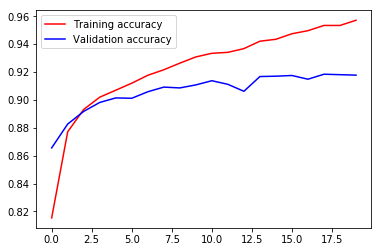

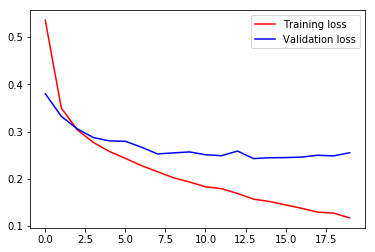

In [0]:
plot_progress(history_cnn1)

Next we try a different model and see if we achieve different results...



## 3-Conv CNN (`model_cnn2`)

In this model, we'll be using three Convolution layers. The sequence is...

(`conv_layer21`)\[ Conv ---> MaxPool ---> DropOut] ---><br>
(`conv_layer22`)\[ Conv ---> MaxPool ---> DropOut] ---><br>
(`conv_layer23`)\[ Conv ---> DropOut] ---><br>
Unroll ---><br>
(`dense_layer21`)\[ Dense ----> DropOut ] ---><br>
(`dense_layer22`)\[ Dense ]

In [0]:
conv_layer21 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25)
], name="conv_layer21")

conv_layer22 = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25)
], name="conv_layer22")

conv_layer23 = keras.Sequential([
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.Dropout(0.4)
], name="conv_layer23")

dense_layer21 = keras.Sequential([
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3)
], name="dense_layer21")

dense_layer22 = keras.Sequential([
    keras.layers.Dense(10, activation="softmax")  
], name="dense_layer22")

model_cnn2 = keras.Sequential([
    # Conv layers...
    conv_layer21,
    conv_layer22,
    conv_layer23,
    
    # Unrolling...
    keras.layers.Flatten(),
    
    # Dense layer
    dense_layer21,
    dense_layer22
], name="model_cnn2")

print_summary(conv_layer21)
print_summary(conv_layer22)
print_summary(conv_layer23)
print_summary(dense_layer21)
print_summary(dense_layer22)
print_summary(model_cnn2)




conv_layer21 summary--
Model: "conv_layer21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________



conv_layer22 summary--
Model: "conv_layer22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)   

In [0]:
model_cnn2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_cnn2 = model_cnn2.fit(train_images, train_labels, epochs=epochs, 
                              validation_data=(cv_images, cv_labels), batch_size=batch_size)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 42us/sample - loss: 0.8738 - acc: 0.6692 - val_loss: 0.5605 - val_acc: 0.7862
Epoch 2/20
48000/48000 [==============================] - 2s 33us/sample - loss: 0.5445 - acc: 0.7943 - val_loss: 0.4502 - val_acc: 0.8307
Epoch 3/20
48000/48000 [==============================] - 2s 33us/sample - loss: 0.4706 - acc: 0.8232 - val_loss: 0.4017 - val_acc: 0.8493
Epoch 4/20
48000/48000 [==============================] - 2s 33us/sample - loss: 0.4230 - acc: 0.8447 - val_loss: 0.3538 - val_acc: 0.8690
Epoch 5/20
48000/48000 [==============================] - 2s 33us/sample - loss: 0.3889 - acc: 0.8569 - val_loss: 0.3248 - val_acc: 0.8798
Epoch 6/20
48000/48000 [==============================] - 2s 33us/sample - loss: 0.3643 - acc: 0.8646 - val_loss: 0.3051 - val_acc: 0.8852
Epoch 7/20
48000/48000 [==============================] - 2s 33us/sample - loss: 0.3450 - acc: 0.8718 - val_loss: 0.

In [0]:
cv_loss, cv_acc = model_cnn2.evaluate(cv_images, cv_labels)
train_loss, train_acc = model_cnn2.evaluate(train_images, train_labels)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)

48000/48000 [==============================] - 2s 50us/sample - loss: 0.1785 - acc: 0.9345
Training loss 0.17849352174966285
Cross Validation loss:  0.23582231223583222
Training accuracy 0.9345
Cross Validation accuracy:  0.912


We get a 91.7% accuracy on the training set and 90.6 accuracy on the CV set. CV accuracy seems to have gone down from the last model. I wonder why...🧐 Loss is looking good though...

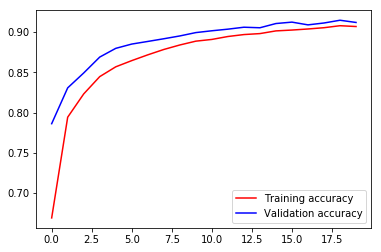

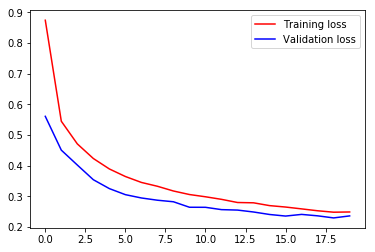

In [0]:
plot_progress(history_cnn2)

## 4-Conv CNN (`model_cnn3`)

This time we use a 4 convolutional layers. I summarise the model below... <br><br>

(`conv_layer31`)\[Conv --> BatchNorm] --> <br>
(`conv_layer32`)\[Conv --> BatchNorm --> MaxPool --> DropOut] => <br>
(`conv_layer33`)\[Conv --> BatchNorm --> Dropout] ---> <br> (`conv_layer34`)\[Conv --> BatchNorm --> MaxPool --> DropOut]  => <br>
Unroll --> <br>
(`dense_layer31`)\[Dense --> BatchNorm --> DropOut] --> <br>(`dense_layer32`)\[Dense --> BatcNorm --> DropOut] --> <br>(`dense_layer33`)\[Dense]

In [0]:
conv_layer31 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.BatchNormalization()
], name="conv_layer31")

conv_layer32 = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25)
], name="conv_layer32")

conv_layer33 = keras.Sequential([
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25)
], name="conv_layer33")

conv_layer34 = keras.Sequential([
    keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25)
], name="conv_layer34")

dense_layer31 = keras.Sequential([
    keras.layers.Dense(512, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5)
], name="dense_layer31")

dense_layer32 = keras.Sequential([
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5)
], name="dense_layer32")

dense_layer33 = keras.Sequential([
    keras.layers.Dense(num_classes, activation="softmax")
], name="dense_layer33")


# Bringing everything together...
model_cnn3 = keras.Sequential([
    
    # Conv layers
    conv_layer31,
    conv_layer32,
    conv_layer33,
    conv_layer34,
    
    # Unrolling...
    keras.layers.Flatten(),
    
    # Dense layers
    dense_layer31,
    dense_layer32,
    dense_layer33
], name="model_cnn3")

print_summary(conv_layer31)
print_summary(conv_layer32)
print_summary(conv_layer33)
print_summary(conv_layer34)
print_summary(dense_layer31)
print_summary(dense_layer32)
print_summary(dense_layer33)
print_summary(model_cnn3)




conv_layer31 summary--
Model: "conv_layer31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
Total params: 448
Trainable params: 384
Non-trainable params: 64
_________________________________________________________________



conv_layer32 summary--
Model: "conv_layer32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)

In [0]:
model_cnn3.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_cnn3 = model_cnn3.fit(train_images, train_labels, epochs=epochs, 
                              validation_data=(cv_images, cv_labels), batch_size=batch_size)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 11s 219us/sample - loss: 0.6300 - acc: 0.7827 - val_loss: 3.0631 - val_acc: 0.1001
Epoch 2/20
48000/48000 [==============================] - 9s 186us/sample - loss: 0.3751 - acc: 0.8673 - val_loss: 1.9780 - val_acc: 0.4383
Epoch 3/20
48000/48000 [==============================] - 9s 187us/sample - loss: 0.3078 - acc: 0.8918 - val_loss: 0.4345 - val_acc: 0.8349
Epoch 4/20
48000/48000 [==============================] - 9s 189us/sample - loss: 0.2805 - acc: 0.9016 - val_loss: 0.2480 - val_acc: 0.9100
Epoch 5/20
48000/48000 [==============================] - 9s 190us/sample - loss: 0.2483 - acc: 0.9126 - val_loss: 0.2480 - val_acc: 0.9108
Epoch 6/20
48000/48000 [==============================] - 9s 190us/sample - loss: 0.2322 - acc: 0.9174 - val_loss: 0.2465 - val_acc: 0.9140
Epoch 7/20
48000/48000 [==============================] - 9s 190us/sample - loss: 0.2154 - acc: 0.9241 - val_

In [0]:
cv_loss, cv_acc = model_cnn3.evaluate(cv_images, cv_labels)
train_loss, train_acc = model_cnn3.evaluate(train_images, train_labels)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)

48000/48000 [==============================] - 4s 84us/sample - loss: 0.0495 - acc: 0.9823
Training loss 0.049512997156668764
Cross Validation loss:  0.24520523769160113
Training accuracy 0.98229164
Cross Validation accuracy:  0.92758334


Okay, so after 20 iterations our training accuracy is now a whopping 97% and CV accuracy is at a 94%. Looking at the loss graph below, it seems that the loss had started to increase in the last few epochs.

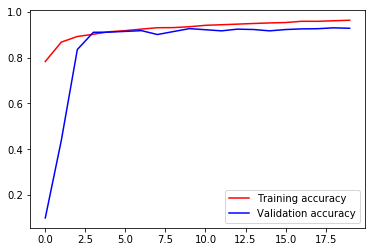

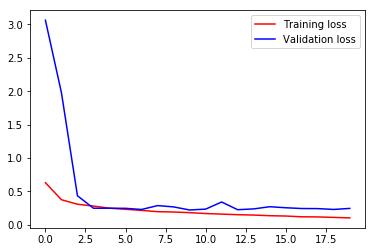

In [0]:
plot_progress(history_cnn3)

We next plot each of the 4 metrics - Training loss, training accuracy, CV loss, CV accuracy for all three models and try to discover any underlying trends. There is nothing out of the oridinary here, except for the fact that `model_cnn2` seems to perform poorly on the training set for some reason. I wonder why...🧐

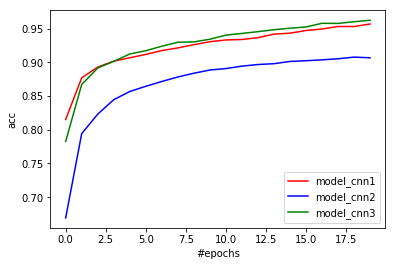

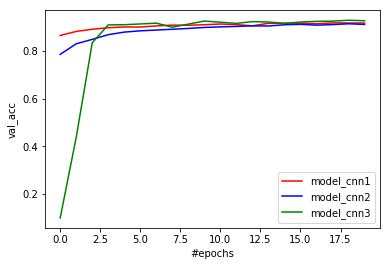

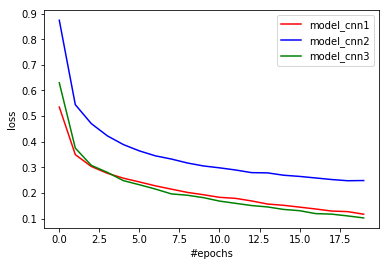

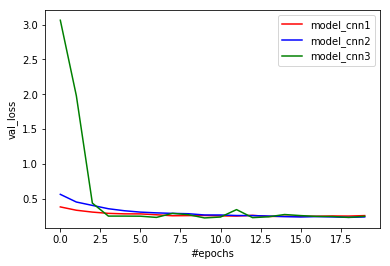

In [0]:
plot_metric_across_models((history_cnn1, history_cnn2, history_cnn3), 'acc', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn1, history_cnn2, history_cnn3), 'val_acc', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn1, history_cnn2, history_cnn3), 'loss', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn1, history_cnn2, history_cnn3), 'val_loss', ('r', 'b', 'g'))

## Data Augmentation

We now perform a series a data augmentations. Data Augmentation is a collection of crafty techniques that can be used to populate our training data. This is helpful if we have a modest dataset to work with. Simple models work well with a lot of training data. Since our models **are** simple, this is something we can use in this situation.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                              height_shift_range=0.08, zoom_range=0.08)

train_batches = generator.flow(train_images, train_labels, batch_size=256)
val_batches = generator.flow(cv_images, cv_labels, batch_size=256)

We now proceed to further train our models on this new data. This should definitely improve our models, make them more robust.

In [0]:
history_cnn12 = model_cnn1.fit_generator(train_batches, epochs=50, 
                                         validation_data=val_batches, use_multiprocessing=True)

In [0]:
history_cnn22 = model_cnn2.fit_generator(train_batches, epochs=50, 
                                         validation_data=val_batches, use_multiprocessing=True)

In [0]:
history_cnn32 = model_cnn3.fit_generator(train_batches, epochs=50, 
                                         validation_data=val_batches, use_multiprocessing=True)

In [0]:
cv_loss, cv_acc = model_cnn1.evaluate(train_batches)
train_loss, train_acc = model_cnn1.evaluate(val_batches)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)
plot_progress(history_cnn12)

Nothing interesting here, except for the increase in the training loss (0.1419 ----> 0.259). Accuracy is somewhat similar to what we saw earlier.

In [0]:
cv_loss, cv_acc = model_cnn2.evaluate(train_batches)
train_loss, train_acc = model_cnn2.evaluate(val_batches)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)
plot_progress(history_cnn22)

Loss went down and accuracy went up. Data augmentation seems to have somewhat improvevd `model_cnn2`.

In [0]:
cv_loss, cv_acc = model_cnn3.evaluate(train_batches)
train_loss, train_acc = model_cnn3.evaluate(val_batches)

print("Training loss", train_loss)
print("Cross Validation loss: ", cv_loss)
print("Training accuracy", train_acc)
print("Cross Validation accuracy: ", cv_acc)
plot_progress(history_cnn32)

Training loss and accuracy went somewhat down, but there's also an increase in CV metrics for `model_cnn3`.

In [0]:
plot_metric_across_models((history_cnn12, history_cnn22, history_cnn32), 'acc', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn12, history_cnn22, history_cnn32), 'val_acc', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn12, history_cnn22, history_cnn32), 'loss', ('r', 'b', 'g'))
plot_metric_across_models((history_cnn12, history_cnn22, history_cnn32), 'val_loss', ('r', 'b', 'g'))

Looking at this data, `model_cnn3` seems to do exceptionally well than than `model_cnn2` and `model_cnn1` on augmented data. Once again, `model_cnn2` performs worst on training data. I cannot understand why.

## Performance on the test set

In [0]:
test_loss, test_acc = model_cnn1.evaluate(test_images, test_labels)

print("For model_cnn1...")
print("Test loss", test_loss)
print("Test accuracy: ", test_acc)
print("\n")

test_loss, test_acc = model_cnn2.evaluate(test_images, test_labels)

print("For model_cnn2...")
print("Test loss", test_loss)
print("Test accuracy: ", test_acc)
print("\n")

test_loss, test_acc = model_cnn3.evaluate(test_images, test_labels)

print("For model_cnn3...")
print("Test loss", test_loss)
print("Test accuracy: ", test_acc)
print("\n")

The results speak for themselves; `model_cnn3` performs best.

## Saving the model

In [0]:
from keras.models import model_from_json

def save_model(model):
  model_json = model.to_json()
  with open(model.name+".json", "w") as json_file:
    json_file.write(model_json)
  model.save_weights(model.name+".h5")
  print(model.name + " has been saved to disk")

In [0]:
save_model(model_cnn1)
save_model(model_cnn2)
save_model(model_cnn3)

In [0]:
train_loss1, train_acc1 = model_cnn1.evaluate(train_images, train_labels)
train_loss2, train_acc2 = model_cnn2.evaluate(train_images, train_labels)
train_loss3, train_acc3 = model_cnn3.evaluate(train_images, train_labels)

48000/48000 [==============================] - 4s 87us/sample - loss: 0.0495 - acc: 0.9823


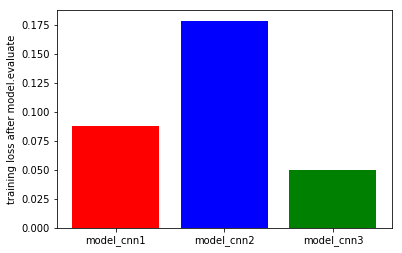

In [0]:
X = ("model_cnn1", "model_cnn2", "model_cnn3")
Y = (train_loss1, train_loss2, train_loss3)
plt.bar(X, Y, color=('r', 'b', 'g'))
plt.ylabel("training loss after model.evaluate")
plt.show()

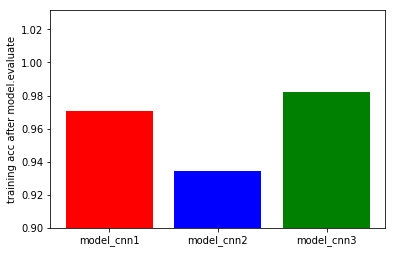

In [0]:
X = ("model_cnn1", "model_cnn2", "model_cnn3")
Y = (train_acc1, train_acc2, train_acc3)
plt.bar(X, Y, color=('r', 'b', 'g'))
plt.axis([None, None, 0.9, None])
plt.ylabel("training acc after model.evaluate")
plt.show()

TypeError: ignored